In [1]:
#Utility
import pandas as pd
pd.set_option('display.max_rows', 2000)
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import os
import sys

# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'

import config as c

## Fetch data

In [2]:
windows = c.windows
number_crypto = c.number_cryptos
market_cap = c.market_cap

df_name = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df_market_cap = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)
df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)

df_market_cap_first_date = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted.csv', index_col=0)
df_CW = pd.read_csv(f"{path_b}data/processed/CW_{number_crypto}_price_FULL.csv", index_col=0)

#find date
first_date = df_market_cap_first_date['first_date_marketcap'].iloc[number_crypto]

#Returns df for number of cryptos
df_returns = df_close_price.drop(df_close_price[df_close_price.index < first_date].index)
df_returns = df_returns.loc[:, df_name['crypto_name']].pct_change()

## Get returns

In [3]:
#only keep dates that match with the market portfolio
df_CW_returns = df_CW.pct_change()
df_CW_returns.index = pd.to_datetime(df_CW_returns.index)
df_returns.index = pd.to_datetime(df_returns.index).tz_localize(None)

df_returns = df_returns[df_returns.index > df_CW_returns.index[0]]

#print(df_vola.index.difference(df_vola_CW.index))
df_returns.drop(pd.to_datetime('2018-05-10'), inplace=True)#drop problematic date

## Get betas

In [4]:
df_returns['CW'] = df_CW_returns.perf
df_returns.dropna(inplace=True)


df_beta = pd.DataFrame(index=df_returns.index, columns=df_returns.columns).iloc[1:]

#calculate betas
for i in df_returns.index[1:]:
    cov = df_returns.loc[:i, :].cov()
    df_beta.loc[i] = cov.iloc[:, -1].values / np.diag(cov)

df_beta = df_beta.iloc[windows:, :]

print(df_beta)

               bitcoin   litecoin   namecoin feathercoin  primecoin  \
datetime                                                              
2016-12-23   94.538997 -56.352327  -11.15385   -7.780133  -17.51293   
2016-12-24   91.780956 -56.091859 -11.098515   -7.765005 -17.484841   
2016-12-25   91.489474  -55.27291 -11.146191   -7.793718 -17.448934   
2016-12-26   90.389326  -55.29337 -10.763593   -7.773536 -18.092322   
2016-12-27   90.812051 -54.286596 -10.244242   -7.430799 -18.054334   
2016-12-28   88.931893 -53.575023 -10.169493    -7.63958 -18.226624   
2016-12-29   88.684237 -53.594725  -9.958745   -7.687527  -18.15947   
2016-12-30   90.129261 -51.263157  -9.680579   -7.723544 -17.500974   
2016-12-31   90.103602 -51.214038  -9.702331   -7.747034 -17.517338   
2017-01-01   105.09212 -42.695557   -6.01052   -4.870711 -17.013618   
2017-01-02  104.660728  -42.03463  -5.922052   -4.863893 -16.671181   
2017-01-03  104.561769  -42.11474  -5.866568   -4.764243 -16.564711   
2017-0

## get weights

In [7]:
df_weights_low = df_beta.iloc[:, :-1].copy() #remove the CW portfolio
df_weights_high = df_beta.iloc[:, :-1].copy() #remove the CW portfolio

avg = pd.Series(df_beta.mean(axis=1), index = df_beta.index)


for i in df_beta.index:
    df_weights_low.loc[i] = df_weights_low.loc[i].apply(lambda x: x if x < avg.loc[i] else 0)
    df_weights_low.loc[i] = df_weights_low.loc[i].apply(lambda x: (x - df_weights_low.loc[i].min())/(df_weights_low.loc[i].max()-df_weights_low.loc[i].min()) if x != 0 else 0)
    df_weights_low.loc[i] = df_weights_low.loc[i]/df_weights_low.loc[i].sum()
    
    df_weights_high.loc[i] = df_weights_high.loc[i].apply(lambda x: x if x > avg.loc[i] else 0)
    df_weights_high.loc[i] = df_weights_high.loc[i].apply(lambda x: (x - df_weights_high.loc[i].min())/(df_weights_high.loc[i].max()-df_weights_high.loc[i].min()) if x != 0 else 0)
    df_weights_high.loc[i] = df_weights_high.loc[i]/df_weights_high.loc[i].sum()

print(df_weights_low.head(1).iloc[:, :6])
print(df_weights_high.head(1).iloc[:, :6])

           bitcoin litecoin  namecoin feathercoin primecoin  peercoin
datetime                                                             
2016-12-23     0.0      0.0  0.086404    0.092853  0.074247  0.079624
            bitcoin litecoin namecoin feathercoin primecoin peercoin
datetime                                                            
2016-12-23  0.28185      0.0      0.0         0.0       0.0      0.0


## create the portfolios

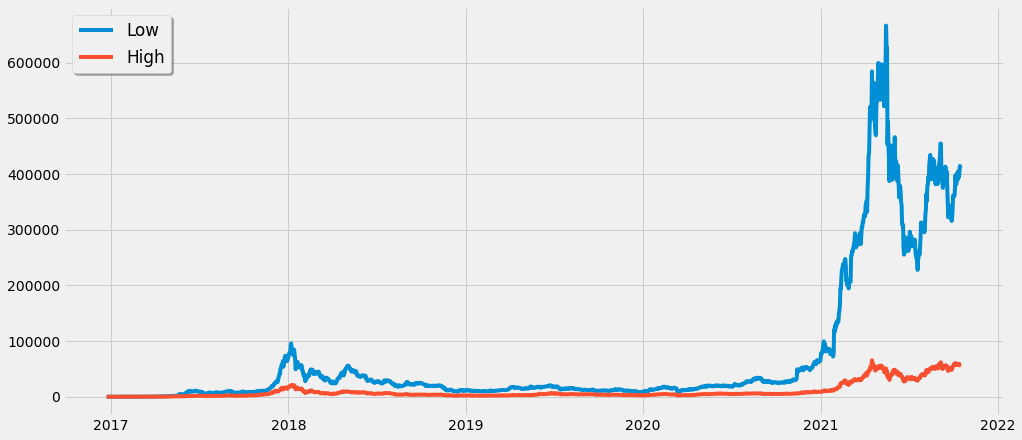

In [8]:
df_returns_adjusted = df_returns.iloc[windows+1:, :].iloc[:, :-1] #covariance calculation problem 


returns_low = df_weights_low*df_returns_adjusted
returns_low = returns_low.sum(axis=1)

returns_high = df_weights_high*df_returns_adjusted
returns_high = returns_high.sum(axis=1)



#setup for starting at 100
returns_low.iloc[0] = 0
returns_high.iloc[0] = 0

price_low = returns_low.add(1).cumprod()*100
price_high = returns_high.add(1).cumprod()*100


price_low.to_csv(f"../data/processed/Low_Beta_{number_crypto}_price.csv")
price_high.to_csv(f"../data/processed/High_Beta_{number_crypto}_price.csv")



plt.figure(figsize=(15,7))
plt.plot(price_low)
plt.plot(price_high)
plt.legend(['Low', 'High'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.show()